# Kernel Approximation using random features
This notebook does kernel approximation for 4 kernels: Gaussian, Laplacian, Matérn, ExpPower using both RFF and ORF approximation schemes

In [1]:
from torchkernels.feature_maps import (
    LaplacianORF, LaplacianRFF,
    GaussianORF, GaussianRFF,
    MaternORF, MaternRFF,
    ExpPowerORF, ExpPowerRFF
    )
from utils import create_kernel_str, create_Kmat_exact, create_plots
import numpy as np
import torch

In [2]:
kernels = ["Gaussian", "Laplacian", "Matern", "ExpPower"]
approximations = ['RFF', 'ORF']
d = 32
length_scale = 1.
nu = 1.5
alpha = 0.7
bias_term = False

In [3]:
kernel_str_dict = {kernel: create_kernel_str(kernel, nu, alpha) for kernel in kernels}

Create radomly oriented vectors $x_1$ and $x_2$ that are a specified distance apart

In [4]:
N = 20
x1_x2_norm = np.linspace(0, 5, N)
x1_list = []
x2_list = []
for i, x_ in enumerate(x1_x2_norm):
    x1 = torch.randn(d)
    x1_x2_u = torch.randn(d)
    x1_x2 = x1_x2_u/np.linalg.norm(x1_x2_u)*x_
    x2 = x1 + x1_x2
    x1 = x1.reshape(1,-1)
    x2 = x2.reshape(1,-1)
    x1_list.append(x1)
    x2_list.append(x2)

Evaluate exactly $K(x_1, x_2)$

In [5]:
K_exact_dict = create_Kmat_exact(kernels=kernels, x1_list=x1_list, x2_list=x2_list, length_scale=length_scale, nu=nu, alpha=alpha)

### Create approximation using random features

In [6]:
p = int(3e4)
K_approx_dict = {}
for kernel in kernels:
    K_approx_dict[kernel] = {}
    for approx in approximations:
        K_approx_dict[kernel][approx] = []
        
        if approx == "RFF":
            K_func_approx = {"Laplacian": LaplacianRFF, "Gaussian": GaussianRFF, "Matern": MaternRFF, "ExpPower": ExpPowerRFF}
        else: 
            K_func_approx = {"Laplacian": LaplacianORF, "Gaussian": GaussianORF, "Matern": MaternORF, "ExpPower": ExpPowerORF}
        
        if kernel == "ExpPower":
            feature_map = K_func_approx[kernel](num_features=p, input_dim=d, length_scale=length_scale, alpha=alpha, bias_term=bias_term)
        elif kernel == "Matern":
            feature_map = K_func_approx[kernel](num_features=p, input_dim=d, length_scale=length_scale, nu=nu, bias_term=bias_term)
        else:
            feature_map = K_func_approx[kernel](num_features=p, input_dim=d, length_scale=length_scale, bias_term=bias_term)
        for x1,x2 in zip(x1_list, x2_list):
            Phi_x1 = feature_map(x1)
            Phi_x2 = feature_map(x2)
            K_approx_dict[kernel][approx].append((Phi_x1@Phi_x2.T)[0].item())

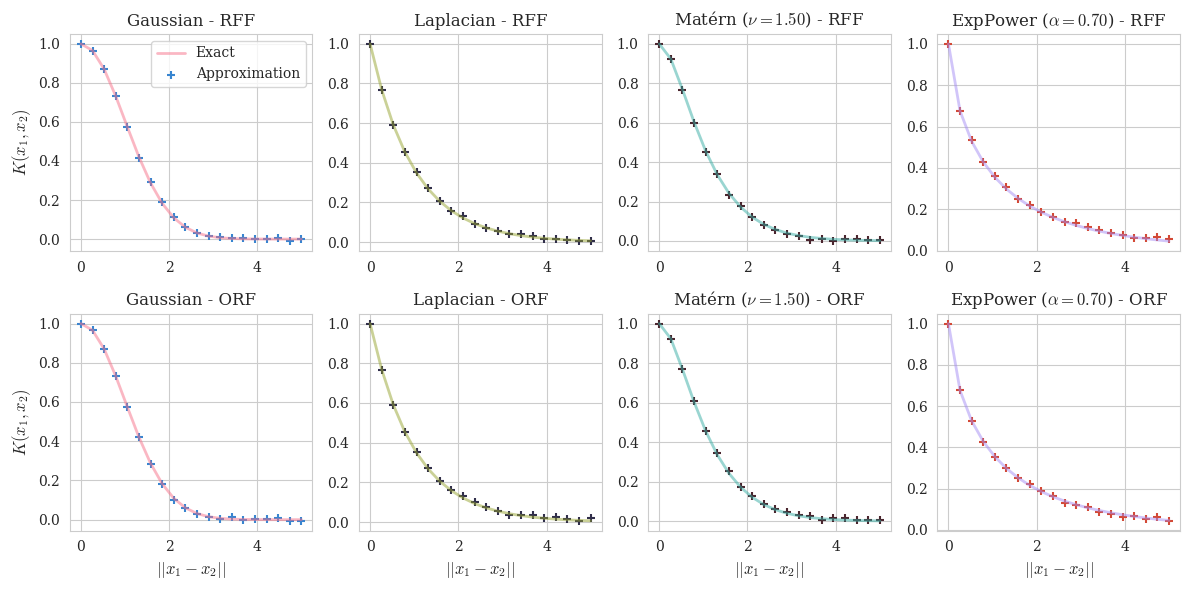

In [7]:
create_plots(kernels=kernels, approximations=approximations, K_exact_dict=K_exact_dict, K_approx_dict=K_approx_dict, x1_x2_norm=x1_x2_norm, kernel_str_dict=kernel_str_dict)